# Compare Time Series between MUR SST Kerchunk and Zarr Stores

Is this a reasonable comparison? There are a few differences

1. The kerchunk store references files in the po.daac bucket, using short term credentials generated via EDL. The Zarr store is in a public AWS s3 bucket
2. The public AWS S3 bucket only goes to January 20, 2020
3. The chunking configuration is different


From: https://github.com/pangeo-gallery/osm2020tutorial/blob/master/AWS-notebooks

-------------------

## Import python packages

It is nice to turn off warnings and set xarray display options.  

In [1]:
import warnings
import fsspec
import metpy
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import os
import sys
sys.path.append(os.path.join(os.environ['HOME'], 'shared', 'users', 'lib'))
import ebdpy as ebd

warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 

# Define some parameters for slicing the data

In [2]:
timeseries_params = {
    'time': slice('2002-06-01','2003-05-31'),
    'lat': 47,
    'lon': -145
}

pac_coast_params = {
    'time': slice('2002-06-01','2002-06-01'),
    'lat': slice(46, 50.99),
    'lon': slice(-128, -123.01)
}

### Open + Test Kerchunk Dataset

In [3]:
%%time
fs = fsspec.filesystem(
    'reference', 
    fo="./new-combined.json", 
    remote_protocol='s3', 
    remote_options=dict(profile='aimee'), 
    skip_instance_cache=True
)
ds_sst_kerchunk = xr.open_dataset(fs.get_mapper(""), engine='zarr')
ds_sst_kerchunk

CPU times: user 25.7 s, sys: 2.73 s, total: 28.4 s
Wall time: 29.8 s


<xarray.Dataset>
Dimensions:           (time: 7380, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2022-08-1...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    sst_anomaly       (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

CPU times: user 9.41 s, sys: 677 ms, total: 10.1 s
Wall time: 1min 30s


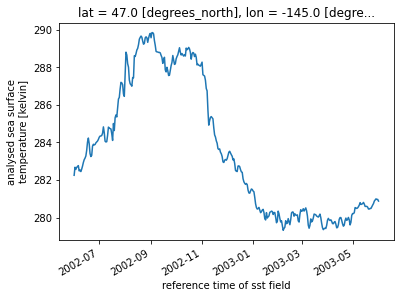

In [4]:
%%time

sst_timeseries = ds_sst_kerchunk['analysed_sst'].sel(**timeseries_params).load()

sst_timeseries.plot()

In [5]:
pac_coast_kerchunked = ds_sst_kerchunk['analysed_sst'].sel(**pac_coast_params)
pac_coast_kerchunked

<xarray.DataArray 'analysed_sst' (time: 1, lat: 499, lon: 500)>
[249500 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 46.0 46.01 46.02 46.03 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float32 -128.0 -128.0 -128.0 -128.0 ... -123.0 -123.0 -123.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [6]:
%%time
pac_coast_kerchunked.load().mean()

CPU times: user 21.8 ms, sys: 4.23 ms, total: 26.1 ms
Wall time: 77.2 ms


<xarray.DataArray 'analysed_sst' ()>
array(284.87018, dtype=float32)

# Open v1 Zarr store

In [7]:
%%time

ds_sst_zarr_v1 = xr.open_zarr('https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1', consolidated=True)
ds_sst_zarr_v1

CPU times: user 762 ms, sys: 52.6 ms, total: 814 ms
Wall time: 1.26 s


,Array,Chunk
Bytes,15.19 TiB,123.53 MiB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,2 Graph Layers,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,123.53 MiB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,2 Graph Layers,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


CPU times: user 10.7 s, sys: 6.1 s, total: 16.8 s
Wall time: 29.2 s


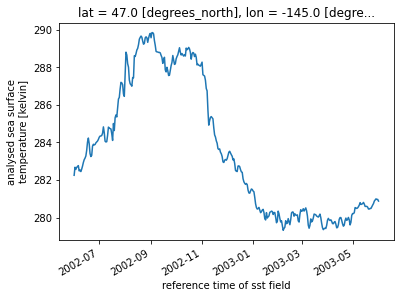

In [8]:
%%time

sst_timeseries = ds_sst_zarr_v1['analysed_sst'].sel(**timeseries_params).load()

sst_timeseries.plot()

In [9]:
pac_coast_zarr_v1 = ds_sst_zarr_v1['analysed_sst'].sel(**pac_coast_params)
pac_coast_zarr_v1

<xarray.DataArray 'analysed_sst' (time: 1, lat: 499, lon: 500)>
dask.array<getitem, shape=(1, 499, 500), dtype=float32, chunksize=(1, 499, 500), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 46.0 46.01 46.02 46.03 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float32 -128.0 -128.0 -128.0 -128.0 ... -123.0 -123.0 -123.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [10]:
%%time
pac_coast_zarr_v1.load().mean()

CPU times: user 215 ms, sys: 94.6 ms, total: 310 ms
Wall time: 894 ms


<xarray.DataArray 'analysed_sst' ()>
array(284.87018, dtype=float32)

# Open v2 Zarr store

In [11]:
%%time

ds_sst_zarr_v2 = xr.open_zarr('https://mur-sst.s3.us-west-2.amazonaws.com/zarr', consolidated=True)
ds_sst_zarr_v2

CPU times: user 660 ms, sys: 43.9 ms, total: 704 ms
Wall time: 1.94 s


,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,2 Graph Layers,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,2 Graph Layers,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


CPU times: user 363 ms, sys: 227 ms, total: 590 ms
Wall time: 3.13 s


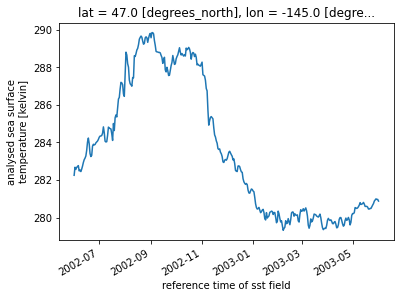

In [12]:
%%time

sst_timeseries = ds_sst_zarr_v2['analysed_sst'].sel(**timeseries_params).load()

sst_timeseries.plot()

In [13]:
pac_coast_zarr_v2 = ds_sst_zarr_v2['analysed_sst'].sel(**pac_coast_params)
pac_coast_zarr_v2

<xarray.DataArray 'analysed_sst' (time: 1, lat: 499, lon: 500)>
dask.array<getitem, shape=(1, 499, 500), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 46.0 46.01 46.02 46.03 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float32 -128.0 -128.0 -128.0 -128.0 ... -123.0 -123.0 -123.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [14]:
%%time
pac_coast_zarr_v2.load().mean()

CPU times: user 7.03 s, sys: 4.43 s, total: 11.5 s
Wall time: 20.1 s


<xarray.DataArray 'analysed_sst' ()>
array(277.29138, dtype=float32)